In [261]:
import numpy as np
from scipy import misc 
from mpl_toolkits.mplot3d import Axes3D 
import matplotlib.pyplot as plt 
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter 
from time import time

In [262]:
%matplotlib notebook

In [263]:
def U(x, t): return x*t + np.exp(-(3*np.pi*0.5)**2*t)*np.sin(3*np.pi*x*0.5) 

In [264]:
def U_t(x, t): return misc.derivative(lambda s: U(x, s), t, 1e-6)

In [265]:
def U_xx(x, t): return misc.derivative(lambda s: U(s, t), x, 1e-6, 2)

In [266]:
def f(x, t): return U_t(x, t)-U_xx(x, t)

In [267]:
def f_t(x, t): return misc.derivative(lambda s: f(x, s), t, 1e-6) 

In [268]:
def f_xx(x, t): return misc.derivative(lambda s: f(s, t), x, 1e-6, 2)

In [269]:
def w(t, a, alph): return U(a, t)-(misc.derivative(lambda s: U(s, t), a, 1e-6)/alph)

In [270]:
def r(t, b): return misc.derivative(lambda s: U(s, t), b, 1e-6) 

In [271]:
def Perm(n, k):
    if k == 0:
        return 1
    elif k > n:
        return 0
    else:
        return Perm(n - 1, k) + Perm(n - 1, k - 1)

In [272]:
def del_p(A, b, p):
    b[0] -= b[p-1]*A[0][p]/A[p-1][p]
    A[0] = [A[0][j] - A[0][p]*A[p-1][j]/A[p-1][p] for j in range(p+1)]+[0.0 for j in range(p+1, len(A[0]))]
    return A, b

In [273]:
def toTri(A, b, p):
    if p <= 1: return A, b
    else:
        A, b = del_p(A, b, p)
        return toTri(A, b, p-1)

In [274]:
def TDMA(A, B, p1, p2):
    A, B = toTri(A, B, p1)
    A, B = toTri(np.rot90(A, 2), np.flip(B, 0), p2)
    A, B = np.rot90(A, 2), np.flip(B, 0)
    
    KSI = [0]
    ETA = [0]

    for i in range(len(A)):
        if(i == 0):
            ksi = -A[i][i+1]/A[i][i]
            eta = (B[i])/(A[i][i])
            KSI.append(ksi)
            ETA.append(eta)
        elif(i == len(A)-1):
            ksi = 0
            eta = (B[i] - A[i][i-1]*ETA[i])/(A[i][i-1]*KSI[i] + A[i][i])
            KSI.append(ksi)
            ETA.append(eta)
        else:
            ksi = -A[i][i+1]/(A[i][i-1]*KSI[i] + A[i][i])
            eta = (B[i] - A[i][i-1]*ETA[i])/(A[i][i-1]*KSI[i] + A[i][i])
            KSI.append(ksi)
            ETA.append(eta)
        
    X = [ETA[len(A)]]

    for i in range(len(B)-1, -1, -1):
        x = KSI[i+1]*X[0] + ETA[i+1]
        X.insert(0, x)

    X.pop()
    return X

In [275]:
def SHE(a, b, t0, T, N, M, alph, p1, p2, sigma, g_ap):
    x_nod = np.linspace(a, b, N+1)
    t_nod = np.linspace(t0, T, M+1)
    h, tau = (b-a)/N, (T-t0)/M
    COEF = np.zeros((N+1, N+1))
    Us = np.zeros((M+1, N+1))
    A, bm = np.zeros((N+1, N+1)), np.zeros(N+1)
    if sigma == 0.5-h**2/(12*tau):
        print("hui")
        try: g = { 
            0: lambda x, t: f(x, t) + tau*0.5*f_t(x, t) + (h**2/12)*f_xx(x, t), 
            1: lambda x, t: 0.5*(f(x, t+tau) + f(x, t)) + (f(x-h, t)-2*f(x, t)+f(x+h,t))/12, 
            2: lambda x, t: f(x, t+tau*0.5) + (f(x-h, t+tau*0.5)-2*f(x, t+tau*0.5)+f(x+h,t+tau*0.5))/12
        }[g_ap]
        except KeyError as e:
            g = lambda x, t: f(x, t)
    else:
        g = lambda x, t: f(x, t)
    C = [0.0] + [(-1)**(m+1)*Perm(p1, m)/m for m in range(1, p1+1)]
    B = [0.0] + [(-1)**(m+2)*Perm(p2, m)/m for m in range(1, p2+1)]
    B[0], C[0] = -sum(B), -sum(C)
    COEF[0] = [1.0 - C[0]/(alph*h)] + [float(C[m]/(alph*h)) for m in range(1, p1+1)] + [0.0 for j in range(p1+1, N+1)]
    COEF[N] = [0.0 for j in range(N-p2)] + list(map(lambda x: float(x/h), B))[::-1] 
    for j in range(1, N): COEF[j][j-1], COEF[j][j], COEF[j][j+1] = sigma, (-h**2-2*sigma*tau)/tau, sigma
    Us[0] = [U(x_i, 0) for x_i in x_nod]
    for n in range(M):
        A, bm[0], bm[N] = np.copy(COEF), w(t_nod[n+1], a, alph), r(t_nod[n+1], b) 
        for j in range(1, N):
            bm[j] = -((1-sigma)*Us[n][j+1] + ((h**2-2*(1-sigma)*tau)/tau)*Us[n][j] 
                     + (1-sigma)*Us[n][j-1] + h**2*g(x_nod[j], t_nod[n]))
        Us[n+1] = TDMA(A, bm, p1, p2)
    return Us, x_nod, t_nod

In [276]:
def SHOW(a, b, t0, T, N, M, alph, p1, p2, sigma, g_ap):
    fig = plt.figure(figsize=plt.figaspect(0.5))
    ax = fig.add_subplot(1, 2, 1, projection='3d')
    tm = time()
    Us, X, T = SHE(a, b, t0, T, N, M, alph, p1, p2, sigma, g_ap)
    X, T = np.meshgrid(X, T) 
    surf = ax.plot_surface(X, T, Us, cmap=cm.coolwarm, linewidth=0, antialiased=False)
    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
    ax.set_xlabel('x')
    ax.set_ylabel('t')
    ax.set_zlabel('u')
    
    ax = fig.add_subplot(1, 2, 2, projection='3d') 
    Ur = U(X, T)
    surf = ax.plot_surface(X, T, Ur, cmap=cm.coolwarm, linewidth=0, antialiased=False)
    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
    ax.set_xlabel('x')
    ax.set_ylabel('t')
    ax.set_zlabel('u')
    
    print("Variance: ", np.amax(np.absolute(Us-Ur)))
    print("RunTime: ", time() - tm)
    plt.show()

<IPython.core.display.Javascript object>


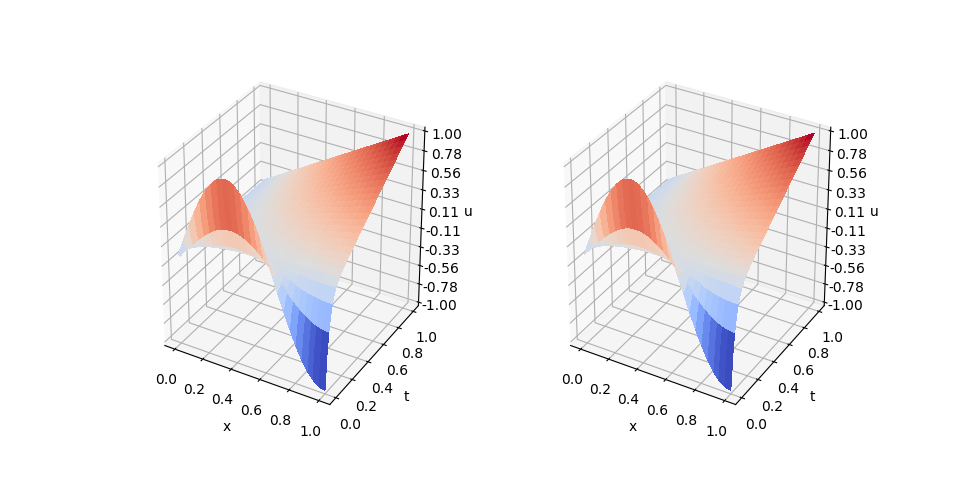

Variance:  0.0436430917739
RunTime:  0.3080177307128906


In [278]:
SHOW(0, 1, 0, 1, 50, 50, -1, 2, 2, 0.5, 10)

#### Example
```
U(x, t): x*t + np.exp(-(3*np.pi*0.5)**2*t)*np.sin(3*np.pi*x*0.5)
f(x, t): x
w(x, t): t+np.exp(-(3*np.pi*0.5)**2*t)*3*np.pi*0.5
r(x, t): t
```